In [1]:
# import jax

# # Get current default device
# current_device = jax.devices()[0]
# print(f"Current default device: {current_device}")

# # Get all available devices
# all_devices = jax.devices()
# print(f"All available devices: {all_devices}")

# # Check if GPU is available
# gpu_available = any(d.platform == 'gpu' for d in jax.devices())
# print(f"GPU available: {gpu_available}")

# # You can also check device platform directly
# platform = jax.devices()[0].platform
# print(f"Platform: {platform}")  # Will show 'cpu', 'gpu', or 'tpu'



In [2]:
import sys
sys.path.append('..')

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from tools.siren import *
from tools.table import *

from tools.simulation import create_siren_grid
from tools.generate import new_differentiable_get_rays

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
#import jax.numpy as jnp

def calculate_opening_angles(ray_vectors, direction):
    # Normalize the direction vector
    direction_norm = direction / jnp.linalg.norm(direction)
    
    # Normalize each ray vector
    # Using axis=1 since shape is (100000, 3)
    ray_vectors_norm = ray_vectors / jnp.linalg.norm(ray_vectors, axis=1)[:, None]
    
    # Calculate dot product between normalized vectors
    # This will give us cos(theta)
    cos_theta = jnp.dot(ray_vectors_norm, direction_norm)
    
    # Calculate opening angles in radians using arccos
    # Clip values to [-1, 1] to avoid numerical errors
    angles = jnp.arccos(jnp.clip(cos_theta, -1.0, 1.0))
    
    return angles

In [4]:
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

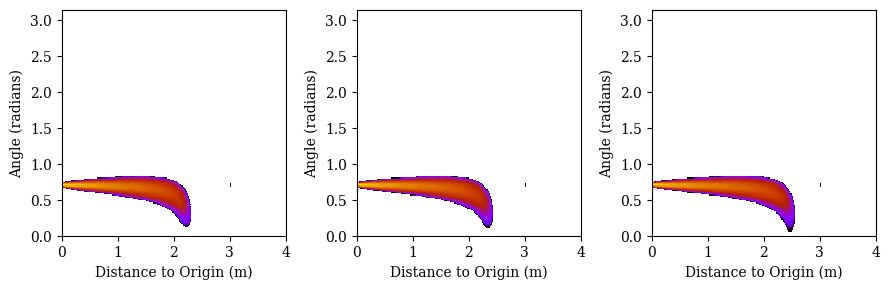

In [5]:
table = Table('cprof_mu_train_10000ev.h5')
table_data = create_siren_grid(table)
siren_model, model_params = load_siren_jax('siren_cprof_mu.pkl')
origin = jnp.array([0.5, 0.0, -0.5])
direction = jnp.array([1.0, -1.0, 0.2])
Nphot = 1_000_000
key = random.PRNGKey(0)

fig, axes = plt.subplots(1,3, figsize=(9,3))

energies = [625, 650, 675]

for i, energy in enumerate(energies):

    ray_vectors, ray_origins, photon_weights = new_differentiable_get_rays(origin, direction, energy, Nphot, table_data, model_params, key)
    
    ranges = jnp.linalg.norm(ray_origins-origin, axis=1)
    angles = calculate_opening_angles(ray_vectors, direction)
    
    h = axes[i].hist2d(ranges, angles, 
                  weights=photon_weights.squeeze(), 
                  bins=[200, 200], 
                  cmap='gnuplot',
                  norm=LogNorm(vmin=1),
                  range=[[0,4], [0,3.14]])

    axes[i].set_ylabel('Angle (radians)')
    axes[i].set_xlabel('Distance to Origin (m)')

fig.patch.set_facecolor('white')
fig.tight_layout()
plt.show()

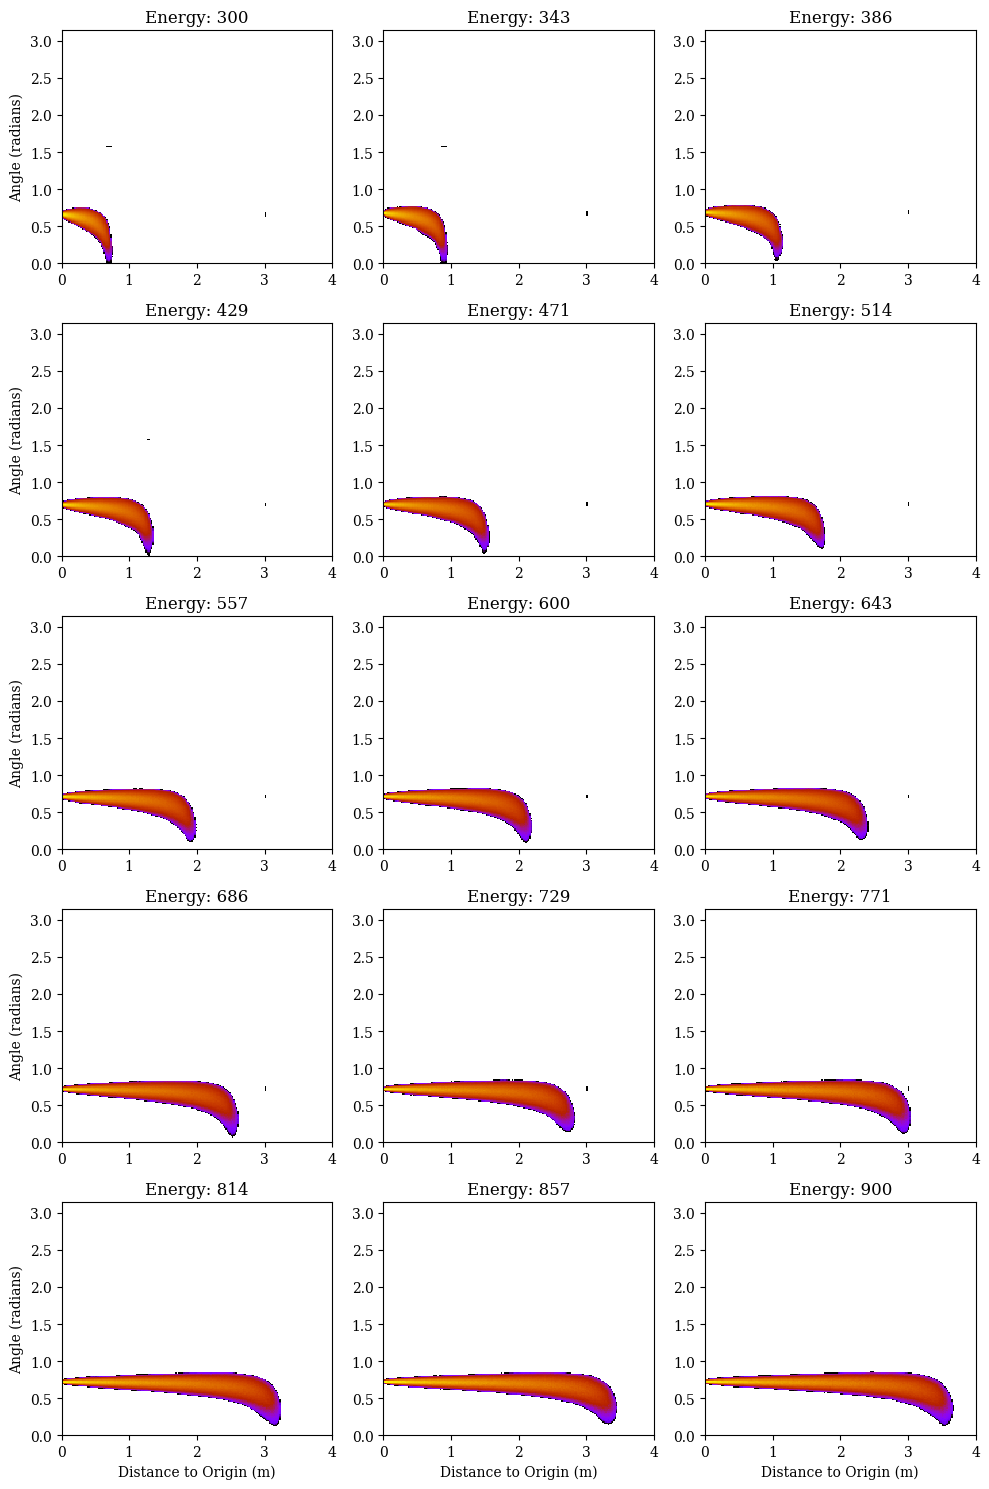

In [6]:
table = Table('cprof_mu_train_10000ev.h5')
table_data = create_siren_grid(table)
siren_model, model_params = load_siren_jax('siren_cprof_mu.pkl')
origin = jnp.array([0.5, 0.0, -0.5])
direction = jnp.array([1.0, -1.0, 0.2])
Nphot = 1_000_000
key = random.PRNGKey(0)

# Create a 3x5 grid of subplots
fig, axes = plt.subplots(5, 3, figsize=(10, 15))

# Calculate energies from 300 to 900 with 15 steps
energies = np.linspace(300, 900, 15)

# Flatten the axes array to make it easier to iterate over
axes_flat = axes.flatten()

for i, energy in enumerate(energies):
    ray_vectors, ray_origins, photon_weights = new_differentiable_get_rays(
        origin, direction, energy, Nphot, table_data, model_params, key
    )
    
    ranges = jnp.linalg.norm(ray_origins-origin, axis=1)
    angles = calculate_opening_angles(ray_vectors, direction)
    
    h = axes_flat[i].hist2d(
        ranges, 
        angles,
        weights=photon_weights.squeeze(),
        bins=[200, 200],
        cmap='gnuplot',
        norm=LogNorm(vmin=0.5),
        range=[[0,4], [0,3.14]]
    )
    
    # Add energy value to the title of each subplot
    axes_flat[i].set_title(f'Energy: {energy:.0f}')
    
    # Only add y-label for leftmost plots
    if i % 3 == 0:
        axes_flat[i].set_ylabel('Angle (radians)')
    
    # Only add x-label for bottom plots
    if i >= 12:
        axes_flat[i].set_xlabel('Distance to Origin (m)')

fig.patch.set_facecolor('white')
fig.tight_layout()
fig.savefig('phot_gen_vs_E.png', dpi=300)
plt.show()